In [1]:
import numpy as np
import jax.numpy as jnp

In [2]:
from qiskit_dynamics.array import Array

# configure jax to use 64 bit mode
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')


# set default backend
Array.set_default_backend('jax')

In [3]:
dim = 5 # dimension cutoff

# truncated annihilation, creation, and number operators
a = jnp.diag(np.sqrt(np.arange(1, dim, dtype=complex)), -1)
adag = a.conj().transpose()
numb = jnp.diag(np.arange(dim, dtype=complex))
ident = np.eye(dim, dtype=complex)

# truncated oscillator X and Y
osc_X = a + adag
osc_Y = 1j*(a-adag)

# model parameters - work in units of GHz/ns
v = 5.0
anharm = -0.33
r = 0.02

ones = np.ones(dim, dtype=complex)
ones[0:2] = np.array([0., 0.])
P = np.diag(ones)

In [4]:
from qiskit_dynamics import DiscreteSignal
from discrete_signals import get_param_to_signal

# choose the size of the cheb basis
cheb_order = 7
# choose # steps of the signal
N = 100

#get the filter
param_to_signal = get_param_to_signal(cheb_order, N)

# maybe determine overall length?
sample_dt = 0.125

T = sample_dt * len(param_to_signal(np.random.rand(2, cheb_order + 1)))

In [5]:
test = DiscreteSignal(samples=param_to_signal(10. * np.random.rand(2, cheb_order + 1)),
                      dt=sample_dt,
                      carrier_freq=v)

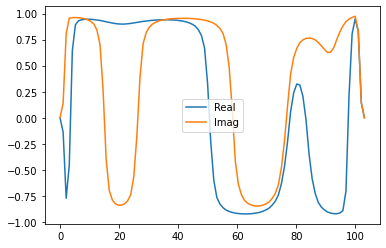

In [6]:
test.draw(0, T, n=100, function='envelope')

In [7]:
X = np.array([[0., 1.], [1., 0.]])

def fidelity(V):
    V = Array(V)
    return np.abs((Array(X) * V[0:2, 0:2]).sum())**2 / 4

In [8]:
from qiskit_dynamics import Solver, DiscreteSignal, RotatingFrame
from qiskit_dynamics.perturbation import solve_lmde_perturbation, ArrayPolynomial
from qiskit_dynamics.array import Array
from jax import jit

from functools import partial
from jax import jit
from jax.scipy.linalg import expm as jexpm

static_hamiltonian = 2 * np.pi * v * numb + np.pi * anharm * numb * (numb - ident)
drive_hamiltonian = 2 * np.pi * r * osc_X

perturb1 = 2 * np.pi * v * numb
perturb2 = np.pi * anharm * numb * (numb - ident)
perturb3 = 2 * np.pi * r * osc_X
perturb4 = 2 * np.pi * r * osc_X
perturb5 = (np.pi / 3) * anharm * numb * (numb - ident) * (numb - 2 * ident)
perturb6 = 2 * np.pi * r * (P @ osc_X @ P)

hamiltonian_operators = [
    drive_hamiltonian,
    perturb1,
    perturb2,
    perturb3,
    perturb4,
    perturb5,
    perturb6
]

solver = Solver(
    static_hamiltonian=static_hamiltonian,
    hamiltonian_operators=hamiltonian_operators,
    rotating_frame=np.diag(static_hamiltonian)
)


def ode_infidelity(control_params, model_params):
    # construct s(b, t)
    samples = param_to_signal(control_params)
    control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
    
    # extract model parameters and set up solver coefficients
    c1, c2, c3, c4, c5, c6 = model_params

    signals = [
        control_signal,
        Array(c1),
        Array(c2),
        control_signal * Array(c3),
        (control_signal * control_signal) * Array(c4),
        Array(c5),
        control_signal * Array(c6)
    ]
    
    solver_copy = solver.copy()
    solver_copy.signals = signals
    
    results = solver_copy.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        atol=1e-10, 
        rtol=1e-10,
        method='jax_odeint'
    )
    
    # return infidelity
    return 1. - fidelity(results.y[-1]).data


rotating_frame = solver.model.rotating_frame

def compute_1d_perturbation_comparison(
    control_params, 
    model_params_dir, 
    perturbation, 
    perturb_vals,
    max_magnus_order=5
):
    """
    Args:
        control_params for params to signal
        model_params_dir for 1d direction in model parameter space
        perturbation is the function computing the perturbation in the lab frame
        perturb_vals is the list of values to plot over
        max_magnus_order is the maximum magnus order to compute up to
    """
    
    # jit function for computing ode fidelity
    ode_func = jit(lambda x: ode_infidelity(control_params, x * model_params_dir))
    
    # compute perturbation terms
    samples = param_to_signal(control_params)
    control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
    
    def generator(t):
        op = control_signal(t) * (-1j * drive_hamiltonian)
        return rotating_frame.operator_into_frame(t, op)
    
    def perturb_in_frame(t):
        op = perturbation(t)
        return rotating_frame.operator_into_frame(t, op)
    
    results = solve_lmde_perturbation(
        perturbations=[perturb_in_frame],
        t_span=[0, T],
        expansion_method='magnus',
        expansion_order=max_magnus_order,
        generator=generator,
        integration_method='jax_odeint',
        rtol=1e-10,
        atol=1e-10
    )
    term_labels = results.perturbation_results.expansion_labels
    perturbation_terms = results.perturbation_results.expansion_terms
    
    # construct magnus expansions for each order from results
    magnus_expansions = []
    for order in range(1, max_magnus_order + 1):
        n_terms = list(map(lambda x: len(x) <= order, term_labels)).count(True)
        magnus_expansion = ArrayPolynomial(
            array_coefficients=perturbation_terms[:n_terms, -1],
            monomial_labels=term_labels[:n_terms]
        )
        magnus_expansions.append(magnus_expansion)
    
    U = results.y[-1]
    
    # get the 1st to 5th order approximate error rates using the Magnus terms
    @partial(jit, static_argnums=(1,))
    def magnus_infidelity(perturb_val, order):

        coeffs = jnp.array([perturb_val])

        U_approx = U @ jexpm(magnus_expansions[order - 1](coeffs).data)

        return 1. - fidelity(U_approx).data
    
    ode_vals = []
    magnus_vals = [[] for _ in range(max_magnus_order)]
    for val in perturb_vals:
        ode_vals.append(ode_func(val))
        
        for order, magnus_val in enumerate(magnus_vals):
            magnus_val.append(magnus_infidelity(val, order + 1))
    
    return ode_vals, magnus_vals

In [10]:
from scipy.integrate import quad

from multiset import Multiset
from qiskit_dynamics.perturbation.perturbation_utils import merge_multiset_expansion_order_labels
from qiskit_dynamics.perturbation.multiset_utils import get_all_submultisets

def polynomial_integrate(f, a, b, degree):
    """Integrate [f(x), x*f(x), ..., (x**degree) * f(x)] over [a, b]."""
    
    results = []
    for k in range(degree + 1):
        integrand = lambda t: (t**k) * f(t)
        results.append(quad(integrand, a, b)[0])
    
    return np.array(results)

def independent_multivariable_integrate(f_list, ranges, max_degree):
    """Return an array of shape (degrees[0] + 1, ..., degrees[-1] + 1),
    whose i[0], ..., i[-1] entry is the integral
    
    (degrees)
    """
    
    one_d_results = []
    for f, [a, b] in zip(f_list, ranges):
        one_d_results.append(polynomial_integrate(f, a, b, max_degree)) 
    
    # construct all multisets up to a given degree
    multisets = merge_multiset_expansion_order_labels(
        perturbation_labels=[[k] for k in range(len(f_list))],
        expansion_order=max_degree
    )
    multisets = get_all_submultisets(multisets)
    
    # prepend the empty multiset
    multisets = [Multiset({})] + multisets

    integration_results = []
    for multiset in multisets:
        res = 1.
        for k in range(len(f_list)):
            res = res * one_d_results[k][multiset.count(k)]
        
        integration_results.append(res)
    
    return np.array(integration_results), multisets

def get_guassian(mean, std):
    
    const = 1 / (std * np.sqrt(2 * np.pi))
    
    return lambda t: const * np.exp(-0.5 * ((t - mean) / std)**2)

In [11]:
##########################################
# magnus order and number of perturbations
##########################################

integration_ranges = [
    [-0.002, 0.002], # frequency
    [-0.1, 0.1], # anharmonicity
    [-1., 1.], # drive strength
    [-1., 1.], # non-linear control term
    [-0.5, 0.5], # higher level spacings
    [-2., 2.] # higher level drive operator
]

means = np.zeros(6, dtype=float)
stds = np.ones(6, dtype=float)

rotating_frame = solver.model.rotating_frame


def construct_magnus_objective(magnus_order, n_perturb):
    """Construct the magnus objective function given an expansion order
    and number of perturbations.
    """


    ##############################
    # compute distribution moments
    ##############################


    f_list = [get_guassian(mean, std) for mean, std in zip(means[:n_perturb], stds[:n_perturb])]

    moments, multisets = independent_multivariable_integrate(
        f_list, 
        ranges=integration_ranges, 
        max_degree=2 * magnus_order
    )

    # normalize in case distribution is cut off
    moments = moments / moments[0]

    ############################################################
    # determine elements to cut based on the integral being zero
    ############################################################
    
    tol=1e-12

    nonzero_idx = []
    nonzero_moments = []
    nonzero_multisets = []
    for idx, (moment, multiset) in enumerate(zip(moments, multisets)):
        if np.abs(moment) > tol:
            nonzero_idx.append(idx)
            nonzero_moments.append(moment)
            nonzero_multisets.append(multiset)

    nonzero_idx = np.array(nonzero_idx)
    nonzero_moments = np.array(nonzero_moments)

    # build function using the above moments
    
    def magnus_computation(params):

        ##############################
        # setup time-dependent signals
        ##############################

        samples = param_to_signal(params)
        control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
        control_signal2 = control_signal * control_signal

        def generator(t):
            op = control_signal(t) * (-1j * drive_hamiltonian)
            return rotating_frame.operator_into_frame(t, op)

        def perturbation1(t):
            op = -1j * perturb1
            return rotating_frame.operator_into_frame(t, op)

        def perturbation2(t):
            op = -1j * perturb2
            return rotating_frame.operator_into_frame(t, op)

        def perturbation3(t):
            op = -1j * control_signal(t) * drive_hamiltonian
            return rotating_frame.operator_into_frame(t, op)

        def perturbation4(t):
            op = -1j * control_signal2(t) * drive_hamiltonian
            return rotating_frame.operator_into_frame(t, op)

        def perturbation5(t):
            op = -1j * perturb5
            return rotating_frame.operator_into_frame(t, op)

        def perturbation6(t):
            op = -1j * control_signal(t) * perturb6
            return rotating_frame.operator_into_frame(t, op)


        perturbations = [
            perturbation1,
            perturbation2,
            perturbation3,
            perturbation4,
            perturbation5,
            perturbation6,
        ]

        perturbations = perturbations[:n_perturb]

        results = solve_lmde_perturbation(
            perturbations=perturbations,
            t_span=jnp.array([0., T]),
            expansion_method='dyson',
            expansion_order=magnus_order,
            generator=generator,
            integration_method='jax_odeint',
            rtol=1e-8,
            atol=1e-8
        )

        # final unitary
        U = results.y[-1]

        ################################
        # construct robustness objective
        ################################
        
        # construct polynomial object
        magnus_terms = results.perturbation_results.expansion_terms[:, -1]
        monomial_labels = results.perturbation_results.expansion_labels

        magnus_polynomial = ArrayPolynomial(
            array_coefficients=magnus_terms,
            monomial_labels=monomial_labels
        )

        # get part acting on computational subspace
        magnus_polynomial = magnus_polynomial[0:dim, 0:2]

        # remove identity component
        magnus_no_id = (
            magnus_polynomial - (magnus_polynomial.trace() * (np.eye(dim, 2, dtype=complex) / 2))
        )

        # construct polynomial for norm, only including nonzero moments
        magnus_norm = magnus_no_id.conj().mul(
            magnus_no_id, monomial_filter=lambda x: x in nonzero_multisets
        ).real.sum()
        
        # final integral is a linear combination of the polynomial coefficients
        robustness_integral = np.dot(magnus_norm.array_coefficients, nonzero_moments[1:]).data

        ##################################
        # fidelity objective
        ##################################

        fid = fidelity(U).data
        #import pdb; pdb.set_trace()
        #############################
        # return linearized objective
        #############################
        return (1 - fid) + robustness_integral / T

    return magnus_computation

# optimize without robustness

In [12]:
rand_control_params = 10. * np.random.rand(2, cheb_order + 1)
rand_control_params.flatten().reshape(2, cheb_order + 1)

array([[2.91976043, 7.73204946, 9.20253775, 6.14340644, 5.3568541 ,
        5.96343212, 3.98756013, 7.1919841 ],
       [8.89430136, 1.06191454, 9.88104937, 7.27626904, 5.83906833,
        8.70484508, 5.82330136, 7.05697751]])

In [13]:
model_params = np.zeros(6, dtype=float)

def no_robust_obj(ctrl_params):
    return ode_infidelity(ctrl_params.reshape(2, cheb_order + 1), model_params)

In [ ]:
from jax.scipy.optimize import minimize
test = minimize(no_robust_obj, rand_control_params.flatten(), method='BFGS')

In [14]:
test.fun

DeviceArray(3.62625024e-08, dtype=float64)

In [15]:
perturb1_vals = jnp.linspace(-0.002, 0.002, 51)

perturb1_results = compute_1d_perturbation_comparison(
    test.x.reshape(2, cheb_order + 1), 
    jnp.array([1., 0., 0., 0., 0., 0.]), 
    perturbation = lambda t: -1j * perturb1, 
    perturb_vals=perturb1_vals,
    max_magnus_order=1
)

Text(0, 0.5, 'Infidelity')

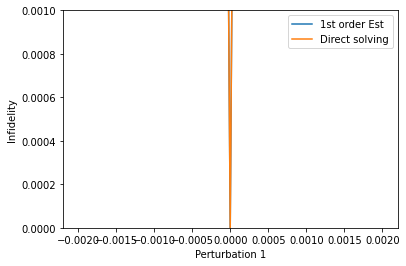

In [16]:
import matplotlib.pyplot as plt

plt.plot(perturb1_vals, perturb1_results[1][0],label='1st order Est')
#plt.plot(perturb1_vals, perturb1_results[1][1],label='2nd order Est')
#plt.plot(perturb1_vals, perturb1_results[1][2],label='3rd order Est')
#plt.plot(perturb1_vals, perturb1_results[1][3],label='4th order Est')
#plt.plot(perturb1_vals, perturb1_results[1][4],label='5th order Est')
plt.plot(perturb1_vals, perturb1_results[0], label='Direct solving')
plt.legend()
plt.ylim(0, 1e-3)
plt.xlabel('Perturbation 1')
plt.ylabel('Infidelity')

In [17]:
magnus_obj = construct_magnus_objective(magnus_order=1, n_perturb=6)

def opt_obj(x):
    return magnus_obj(x.reshape(2, cheb_order + 1))

In [18]:
test2 = minimize(opt_obj, rand_control_params.flatten(), method='BFGS')

In [19]:
test2.fun

DeviceArray(0.0052016, dtype=float64)

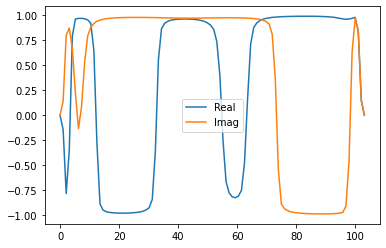

In [20]:
opt_sig = DiscreteSignal(samples=param_to_signal(test2.x.reshape(2, cheb_order + 1)),
                      dt=sample_dt,
                      carrier_freq=v)

opt_sig.draw(0, T, 100, function='envelope')

In [23]:
perturb1_vals = jnp.linspace(-0.1, 0.1, 51)

# compute perturbation terms
samples = param_to_signal(test2.x.reshape(2, cheb_order + 1))
control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
"""
perturb1_results = compute_1d_perturbation_comparison(
    test2.x.reshape(2, cheb_order + 1), 
    jnp.array([0., 0., 1., 0., 0., 0.]), 
    perturbation = lambda t: -1j * control_signal(t) * drive_hamiltonian, 
    perturb_vals=perturb1_vals,
    max_magnus_order=1
)
"""

perturb1_vals = jnp.linspace(-0.002, 0.002, 51)

perturb1_results = compute_1d_perturbation_comparison(
    test.x.reshape(2, cheb_order + 1), 
    jnp.array([1., 0., 0., 0., 0., 0.]), 
    perturbation = lambda t: -1j * perturb1, 
    perturb_vals=perturb1_vals,
    max_magnus_order=1
)

Text(0, 0.5, 'Infidelity')

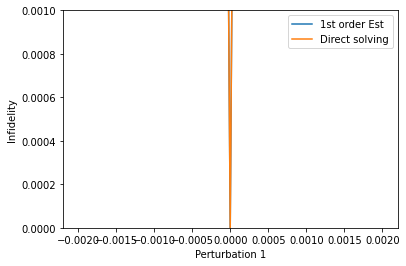

In [24]:
import matplotlib.pyplot as plt

plt.plot(perturb1_vals, perturb1_results[1][0],label='1st order Est')
#plt.plot(perturb1_vals, perturb1_results[1][1],label='2nd order Est')
#plt.plot(perturb1_vals, perturb1_results[1][2],label='3rd order Est')
#plt.plot(perturb1_vals, perturb1_results[1][3],label='4th order Est')
#plt.plot(perturb1_vals, perturb1_results[1][4],label='5th order Est')
plt.plot(perturb1_vals, perturb1_results[0], label='Direct solving')
plt.legend()
plt.ylim(0, 1e-3)
plt.xlabel('Perturbation 1')
plt.ylabel('Infidelity')